## Linear Regression script

#### Build a Linear Regression model to predict and understand x/y locations. 

In [96]:
# Import packages and data
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from data_loader import load_weekly_data, load_supplementary
input_data, output_data = load_weekly_data()
#s_data = load_supplementary()

In [97]:
# Clean tracking data
# Clean orientation and direction
input_data["o_clean"] = (-(input_data["o"] - 90)) % 360
input_data["dir_clean"] = (-(input_data["dir"] - 90)) % 360
# Set x on same scale
input_data["x_clean"] = np.where(
      input_data["play_direction"] == "left",
      120 - input_data["x"],
      input_data[
          "x"
      ], 
  )
# y, s, a alreday clean
input_data["y_clean"] = input_data["y"]
input_data["s_clean"] = input_data["s"]
input_data["a_clean"] = input_data["a"]
# Clean orientation based on play direction
input_data["o_clean"] = np.where(
    input_data["play_direction"] == "left", 180 - input_data["o_clean"], input_data["o_clean"]
)
# Clean orientation, direction, vx, and vy
input_data["o_clean"] = (input_data["o_clean"] + 360) % 360 
input_data["dir_clean"] = (input_data["dir_clean"] + 360) % 360
input_data["dir_radians"] = np.radians(input_data["dir_clean"])
input_data["v_x"] = input_data["s_clean"] * np.cos(input_data["dir_radians"])
input_data["v_y"] = input_data["s_clean"] * np.sin(input_data["dir_radians"])

In [98]:
# Set model and target features based on a given target (x_clean or y_clean)
def build_model(target):
    if target == "x_clean":
        # Set numerical and categorical features
        nums = ['o_clean', 'dir_radians', 'y_clean', 's_clean', 'a_clean', 'v_x', 'v_y']
        cats = ['player_side', 'player_role']
        X = input_data[nums + cats]
        y = input_data[['x_clean']]
    elif target == "y_clean":
        nums = ['o_clean', 'dir_radians', 'x_clean', 's_clean', 'a_clean', 'v_x', 'v_y']
        cats = ['player_side', 'player_role']
        X = input_data[nums + cats]
        y = input_data[['y_clean']]
    return nums, cats, X, y

In [99]:
# Drop NAs from data
input_data = input_data.dropna()
# Apply build model function to predict x
nums, cats, X, y = build_model("x_clean")
# Create preprocessing pipeline to standardize numerical and one-hot encode categorical features
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), nums),
        ("cat", OneHotEncoder(), cats)
    ]
)
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=22903
)
# Build pipeline with Lasso
lasso = Pipeline(steps=[
    ("preprocessor", preprocess),
    ("model", Lasso(alpha=0.1, max_iter=5000))  # alpha can be tuned
])
# Fit the Lasso pipeline
lasso.fit(X_train, y_train)
# get numeric feature names
num_features = nums
# get categorical feature names from OHE
ohe = lasso.named_steps["preprocessor"].named_transformers_["cat"]
cat_features = ohe.get_feature_names_out(cats)
# combine all feature names
all_features = list(num_features) + list(cat_features)
# get Lasso coefficients
coefficients = lasso.named_steps["model"].coef_
# make DataFrame
coef_df = pd.DataFrame({
    "feature": all_features,
    "coefficient": coefficients
})
coef_df

,feature,coefficient
0,o_clean,-0.000000e+00
1,dir_radians,-0.000000e+00
2,y_clean,0.000000e+00
3,s_clean,1.422992e+00
4,a_clean,-1.562154e-01
5,v_x,1.587419e-01
6,v_y,0.000000e+00
7,player_side_Defense,7.075691e+00
8,player_side_Offense,-4.570265e-15
9,player_role_Defensive Coverage,6.013506e-17


From the **lasso** regression model, it appears that the speed, acceleration, and velocity carry the biggest impact in determining where a player is located on the x-axis. It also appears that there is a significant difference when the player is the passer or the player is on defense. 

In [100]:
# Drop NAs from data
# Apply build model function to predict x
nums, cats, X, y = build_model("y_clean")
# Create preprocessing pipeline to standardize numerical and one-hot encode categorical features
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), nums),
        ("cat", OneHotEncoder(), cats)
    ]
)
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=22903
)
# Build pipeline with Lasso
lasso = Pipeline(steps=[
    ("preprocessor", preprocess),
    ("model", Lasso(alpha=0.1, max_iter=5000))  # alpha can be tuned
])
# Fit the Lasso pipeline
lasso.fit(X_train, y_train)
# get numeric feature names
num_features = nums
# get categorical feature names from OHE
ohe = lasso.named_steps["preprocessor"].named_transformers_["cat"]
cat_features = ohe.get_feature_names_out(cats)
# combine all feature names
all_features = list(num_features) + list(cat_features)
# get Lasso coefficients
coefficients = lasso.named_steps["model"].coef_
# make DataFrame
coef_df = pd.DataFrame({
    "feature": all_features,
    "coefficient": coefficients
})
coef_df

,feature,coefficient
0,o_clean,1.854528
1,dir_radians,-0.572843
2,x_clean,0.000000
3,s_clean,-0.000000
4,a_clean,-0.000000
5,v_x,0.000000
6,v_y,2.833877
7,player_side_Defense,0.000000
8,player_side_Offense,-0.000000
9,player_role_Defensive Coverage,0.000000


It only appears that the only variables that can explain the change in y-coordinate movement are player orientation, direction, and velocity in the y direction. 

In [101]:
# build individual linear regression models to predict x and y with statsmodels, specifically with important features (seen via lasso)
import statsmodels.api as sm
import statsmodels.formula.api as smf
x_coord_model  = smf.ols("x_clean ~ C(player_side) + s_clean + a_clean + v_x", data=input_data).fit()
print(x_coord_model.summary())

                            OLS Regression Results                            
Dep. Variable:                x_clean   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                 4.312e+04
Date:                Wed, 26 Nov 2025   Prob (F-statistic):               0.00
Time:                        14:00:41   Log-Likelihood:            -2.2244e+07
No. Observations:             4880579   AIC:                         4.449e+07
Df Residuals:                 4880574   BIC:                         4.449e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [102]:
y_coord_model = smf.ols("y_clean ~ o_clean + dir_radians + v_y", data=input_data).fit()
print(y_coord_model.summary())

                            OLS Regression Results                            
Dep. Variable:                y_clean   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                 2.060e+05
Date:                Wed, 26 Nov 2025   Prob (F-statistic):               0.00
Time:                        14:00:42   Log-Likelihood:            -1.7875e+07
No. Observations:             4880579   AIC:                         3.575e+07
Df Residuals:                 4880575   BIC:                         3.575e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      24.4810      0.012   1991.232      

In [103]:
# Build ridge regression model to predict x and y coords, include all predictors for the sake of prediction
# Apply build model function to predict x
nums, cats, X, y = build_model("x_clean")
# Create preprocessing pipeline to standardize numerical and one-hot encode categorical features
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), nums),
        ("cat", OneHotEncoder(), cats)
    ]
)
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=22903
)
# Build pipeline with Ridge
ridge_x = Pipeline(steps=[
    ("preprocessor", preprocess),
    ("model", Ridge(alpha=0.1))
])
# Fit the Lasso pipeline
ridge_x.fit(X_train, y_train)
# predict x_clean
y_pred_x = ridge_x.predict(X)
### yclean
nums, cats, X, y = build_model("y_clean")
# Create preprocessing pipeline to standardize numerical and one-hot encode categorical features
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), nums),
        ("cat", OneHotEncoder(), cats)
    ]
)
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=22903
)
# Build pipeline with Ridge
ridge_y = Pipeline(steps=[
    ("preprocessor", preprocess),
    ("model", Ridge(alpha=0.1))
])
# Fit the Ridge pipeline
ridge_y.fit(X_train, y_train)
# predict y_clean
y_pred_y = ridge_y.predict(X)
# add predictions to your DataFrame
input_data["x_pred"] = y_pred_x
input_data["y_pred"] = y_pred_y

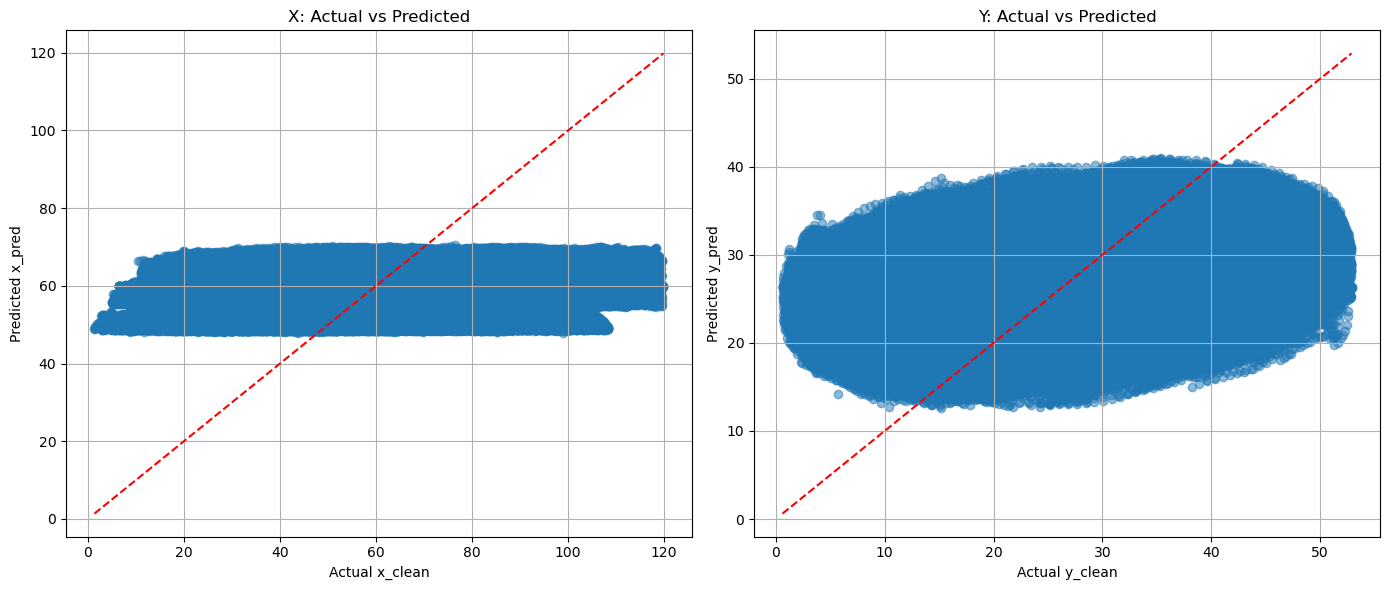

In [104]:
import matplotlib.pyplot as plt

# Create a figure with 2 subplots, side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Scatterplot for X ---
axes[0].scatter(input_data["x_clean"], input_data["x_pred"], alpha=0.5)
axes[0].plot(
    [input_data["x_clean"].min(), input_data["x_clean"].max()],
    [input_data["x_clean"].min(), input_data["x_clean"].max()],
    color="red", linestyle="--"
)
axes[0].set_title("X: Actual vs Predicted")
axes[0].set_xlabel("Actual x_clean")
axes[0].set_ylabel("Predicted x_pred")
axes[0].grid(True)

# --- Scatterplot for Y ---
axes[1].scatter(input_data["y_clean"], input_data["y_pred"], alpha=0.5)
axes[1].plot(
    [input_data["y_clean"].min(), input_data["y_clean"].max()],
    [input_data["y_clean"].min(), input_data["y_clean"].max()],
    color="red", linestyle="--"
)
axes[1].set_title("Y: Actual vs Predicted")
axes[1].set_xlabel("Actual y_clean")
axes[1].set_ylabel("Predicted y_pred")
axes[1].grid(True)

plt.tight_layout()
plt.show()
